# Flow Distribution for the Two Treatment Trains
## Problem Definition
The two 60 L/s trains need proper flow control. They need a flow control system to split the plant flow evenly between the two trains that would enable fine grain flow control. This distribution system should keep flow control for each train independent - such that decreasing one train's flow doesn't increase the other's. 

## Existing Conduction Line
The existing conduction line is composed of two independent pipes of 4" and 6" size. Presumably, one was added after the other in an attempt to augment the flow rate. Two pressure breaks, one for each line, are located 30 meters higher in elevation and 455 meters away from the proposed plant site. By definition, these two pressure breaks have a free surface, and therefore the difference in elevation between the pressure break and the plant's entrance tank represents the maximum available head for delivering, splitting and controlling the flow. The diagram below summarizes the existing system components:

<img src="https://docs.google.com/drawings/d/e/2PACX-1vTYoz334ZI_fy6hpKUyfmm7Ap24bQDkuBVZXC4JJvACmSd-VeLFAUI5RsWscA-FHlxnKEQmn-Kz-H0U/pub?w=1056&h=816">

## Use the Existing 4" and 6" Lines
The simplest solution is to use the current pressure break as the flow distribution system with the two existing lines (4" and 6") as the incoming lines for each train. To make sure this will work, we need to ensure the 4" line can handle the full 60 L/s

In [2]:
from aide_design.play import *
from IPython.display import display
pipe.ID_sch40 = np.vectorize(pipe.ID_sch40)
pipe.ID_sch40 = np.vectorize(pipe.ID_sch40)

In [3]:
##################      Constants         #################
flow_branch = 60 *u.L/u.s
flow_full = flow_branch * 2
nd_pipe_train_4 = 4 *u.inch
sdr_pipe = 17
nd_pipe_train_6 = 6 * u.inch

# these measurements are from Minty's notebook TODO: change to reflect topography study
l_total = 455.06 *u.m
height_pressure_break_4 = 1090.12 * u.m
height_pressure_break_6 = 1091.29 * u.m

# this measurement is from AutoCAD TODO: change to reflect topography study
height_plant = 1058 * u.m

PVC_ROUGHNESS = mat.PIPE_ROUGH_PVC
NU_WATER = exp.NU_WATER 

# a conservative estimate for k TODO: change to reflect actual accessories
k_conduction_line = exp.K_MINOR_EL90 * 7

# Getting function inputs into simple form
head_4 = height_pressure_break_4 - height_plant
head_6 = height_pressure_break_6 - height_plant
id_4 = pipe.ID_SDR(nd_pipe_train_4, sdr_pipe)
id_6 = pipe.ID_SDR(nd_pipe_train_6, sdr_pipe)

#################### headloss calculations    ############################

headloss_train_4 = pc.headloss(flow_branch, id_4, l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)
headloss_train_6 = pc.headloss(flow_branch, id_6, l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)

print("Headloss in 4 inch line: " + str(headloss_train_4) + " and available head is: " + str(head_4))
print("Headloss in 6 inch line: " + str(headloss_train_6) + " and available head is: " + str(head_6))

##################### total flow calculation    ###########################

flow_4 = pc.flow_pipe(id_4,head_4,l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)
flow_6 = pc.flow_pipe(id_6,head_6,l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)
flow_actual_with_two_lines = (flow_4 + flow_6).to(u.L/u.s)

print("Flow to the plant with both lines and available head is: " + str(flow_actual_with_two_lines))

Headloss in 4 inch line: 289.9 meter and available head is: 32.12 meter
Headloss in 6 inch line: 40.36 meter and available head is: 33.29 meter
Flow to the plant with both lines and available head is: 74.31 liter / second


## Changing the Pipes
The headloss in both the 4" and 6" lines is too great to handle the {{flow_branch}} flow rate. Therefore larger diameter pipe needs to be installed to reduce the headloss in the conduction line(s). There are multiple options for how to both increase the conduction line capacitiy and split the flow efficiently:

* Distribution box at the plant with one large conduction line running from the existing plants.
* Distribution box at the location of the current pressure breaks, with two lines running to the plant, one for each train.
* Combine the flow with Ys from the two current pressure breaks into a large line, and split at the plant into each train

The first two options involve the construction of a distribution box, an unnecessary, more complex and expensive solution. All options will use two gate valves (one for each train) at each train entrance tank for fine-grain control of each flow rate. The third option will be investigated first, as it is the simplest to construct, the least expensive, and has no functional drawbacks.

To size the main trunk line, an appropriate target headloss must be chosen. Below is a graph that lists the headloss at different pipe sizes given the parameters of this plant:

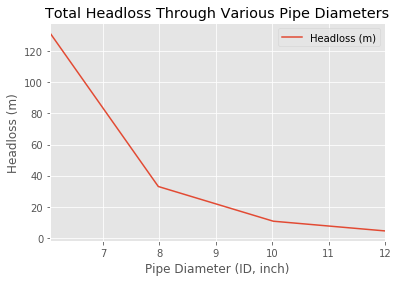

,Headloss (m)
"Pipe Diameter (ID, inch)",
6.065,131.7
7.981,32.98
10.02,10.63
12.0,4.383


In [4]:
# Make a table with available pipe sizes
pipe_sdr = 26
pipe_diameters_nd = [6,8,10,12]#*u.inch
pipe_diameters_id = pipe.ID_sch40(pipe_diameters_nd)
headloss_various_diameters = pc.headloss(flow_full, pipe_diameters_id*u.inch, 
                                         l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)
df = pd.DataFrame(np.array(headloss_various_diameters.magnitude), index=pipe_diameters_id, columns=['Headloss (m)'])

#Graph headloss for different pipe diameters
df.index.name = 'Pipe Diameter (ID, inch)'
df.name = 'Total Headloss Through Various Pipe Diameters'
df.plot().set(ylabel="Headloss (m)", title = df.name)
plt.show()
display(df)

Using a 10 inch or 12 inch pipe would potentially leave enough remaining available headloss to use for flow control. 

## Flow Distribution
Now the question is about flow distribution. The effect of shutting off one train potentially effects the flow rate of the other. Determining the extent of this effect is a flow distribution problem, much like those done throughout plant design. By studying the various flow paths, one can determine the effect of shutting off a flow path during the worst case scenario. There are several steps to designing the optimal system. First, the goal is to reduce the headloss in the shared line, because that headloss changes when one branch is turned off and the flow rate is halved. As the shared headloss reduces, the leftover headloss is taken up by the remaining line, increasing train flow. The steps to define the optimal pipe configuration are as follows:

1. Pipe Length Geometry: make a guess for the ideal pipe geometry, attempting to minimize shared headloss and maximize train branch headloss.
2. Headloss Calculations: determine minor and major losses throughout the system.
3. System Error (Cross-Talk Effect): calculate the effect of cross-talk over a range of flow rates.

### 1. Pipe Length Geometry

The initial pipe design is based on limited knowledge of the site, and is supposed to convey a conservative guess for the condction and distribution line geometry. When a full topography of the site and the two upstream pressure breaks, a more precise design will be made and analyzed. The video below is a rendering of the preliminary design of the conduction and train-distribution system:

[![Gracias Pipe System](https://i.ytimg.com/vi/rrisS073HYU/hqdefault.jpg?sqp=-oaymwEXCNACELwBSFryq4qpAwkIARUAAIhCGAE=&amp;rs=AOn4CLD_nd9y84VffIrXDJmTwNGN4aAsyw)](https://www.youtube.com/watch?v=rrisS073HYU "Gracias Pipe System")

In summary, the proposed plan is to augment both lines running from the pressure break to 8" lines. The two lines will immediately plumb into a main 12" conduction line. The main line will run 455 m to the plant site, where it splits at a tee into two 4" lines. The following calculations ensure the cross-talk between the two trains are minimized. 

### 2. Headloss Calculations

The headloss in the various components of the system is critical in calculating the effect of cross-talk.

#### Headloss From the Pressure Break to the Tee

The first section of the conduction line is where the two smaller lines join the 10" conduction line. To calculate the headloss through the two pipes, an iterative approach is used. First, the flowrates for various headlosses through the 6" and 4" lines combined are calculated. Because the head of the 4" and 6" line is known to be the same at the Tee, it is assumed that the headloss is the same (pressure breaks have the same free surface.) When these two added flow rates together equal the full plant flow rate, the resulting headloss through both pipes represent the first losses in the distribution system: 


k value in 6 inch line: 1.441 dimensionless
k value in 4 inch line: 2.129 dimensionless


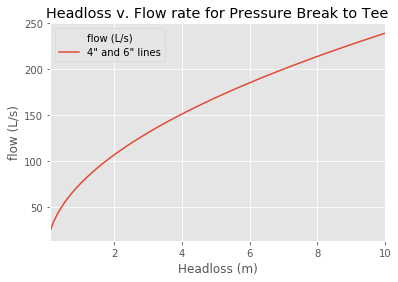

In [5]:
id_12 = pipe.ID_SDR(12, sdr_pipe)

# conservative minor loss coefficient in both lines pressure break to tee:
k_value_pressure_break_to_tee_6_inch = exp.K_MINOR_PIPE_ENTRANCE + \
    exp.K_MINOR_90 + k.k_value_expansion(id_6, id_12, flow_branch)
k_value_pressure_break_to_tee_4_inch = exp.K_MINOR_PIPE_ENTRANCE + \
    exp.K_MINOR_90 + exp.K_MINOR_EL45 + k.k_value_expansion(id_4, id_12, flow_branch)

print("k value in 6 inch line: " + str(k_value_pressure_break_to_tee_6_inch))
print('k value in 4 inch line: ' + str(k_value_pressure_break_to_tee_4_inch))

# conservative pipe lengths from pressure break to tee:
l_pressure_break_to_tee_6_inch = 4 * u.m
l_pressure_break_to_tee_4_inch = 4 * u.m

# determine headloss through both 4" and 6" pipes by defining headloss range:
headloss_range_pressure_break_to_tee = np.linspace(0.1,10,100) * u.m
# calculate the added flow rates for all the headlosses in the range:
flow_range_pressure_break_to_tee = pc.flow_pipe(id_4, headloss_range_pressure_break_to_tee, 
                                                l_pressure_break_to_tee_4_inch, exp.NU_WATER, mat.PIPE_ROUGH_PVC,
                                               k_value_pressure_break_to_tee_4_inch) + \
    pc.flow_pipe(id_6, headloss_range_pressure_break_to_tee, 
                                                l_pressure_break_to_tee_6_inch, exp.NU_WATER, mat.PIPE_ROUGH_PVC,
                                               k_value_pressure_break_to_tee_6_inch)

# graph of flow rates for various flow rates:
df = pd.DataFrame(np.array(flow_range_pressure_break_to_tee.to(u.L/u.s)), 
                                                     index=np.array(headloss_range_pressure_break_to_tee), 
                                                     columns = ['4" and 6" lines'])
df.index.name = 'Headloss (m)'
df.columns.name = 'flow (L/s)'
df.name = 'Headloss v. Flow rate for Pressure Break to Tee'
df.plot().set(ylabel=df.columns.name, title=df.name)
plt.show()


3 m of head is lost to the entrance in order to supply the full plant flow. This is a significant portion of the full head available, and is in the shared headloss section, meaning it will negatively impact the flow distribution cross-talk error. Increasing the two lines to 8" would decrease the headloss substantially, and not require too much work:

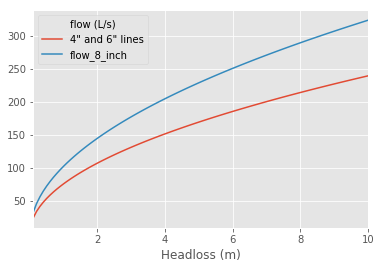

In [6]:
# id of 8" pipe
diam_8 = pipe.ID_SDR(6, sdr_pipe)
# calculate the added flow rates for all the headlosses in the range:
flow_range_pressure_break_to_tee = pc.flow_pipe(diam_8, headloss_range_pressure_break_to_tee, 
                                                l_pressure_break_to_tee_4_inch, exp.NU_WATER, mat.PIPE_ROUGH_PVC,
                                               k_value_pressure_break_to_tee_4_inch) + \
    pc.flow_pipe(diam_8, headloss_range_pressure_break_to_tee, 
                                                l_pressure_break_to_tee_6_inch, exp.NU_WATER, mat.PIPE_ROUGH_PVC,
                                               k_value_pressure_break_to_tee_6_inch)

# dataframe of flow rates for various flow rates:
df = df.assign(flow_8_inch=np.array(flow_range_pressure_break_to_tee.to(u.L/u.s)))
df.plot()
plt.show()

Now the required headloss is less than 1 m, wich will help reduce shared headloss dramatically. 

#### Total Shared (Trunk) Headloss

Now a conservative estimate of the headloss from the main conduction line is added to form the total shared headloss. The remaining head is used in the branch lengths. Using so much head to drive the flow through each branch leads to using smaller pipes and thus smaller gate valves. The following calculations prove that a 6" branch pipe diameter can be used and still achieve the full train flow rate.

In [7]:
# set a conservative guess for a pressure break to tee headloss determined above:
headloss_pressure_break_to_tee = 1 * u.m

# headloss in the combined trunk:
headloss_conduction_line = pc.headloss(flow_full, 12*u.inch, 
                                         l_total,NU_WATER,PVC_ROUGHNESS,k_conduction_line)

# total shared headloss:
headloss_shared = headloss_conduction_line + headloss_pressure_break_to_tee

# set the headloss available as the difference in height from pressure break to plant entrance:
head_available_total = min(height_pressure_break_4, height_pressure_break_6) - height_plant
head_available_for_trains = head_available_total - headloss_shared

print('The total shared headloss is: ' + str(headloss_shared))
print('The remaining headloss available for each train: ' + str(head_available_for_trains))

# calculate the headloss for various pipe sizes for a singe train branch:
pipe_diameters_nd_branch = [3,4,6,8]*u.inch
pipe_diameters_id_branch = pipe.ID_sch40(pipe_diameters_nd_branch)*u.inch

# calculate minor losses:
k_value_tee_to_plant_entrance = k.k_value_reduction(id_12, pipe_diameters_id_branch, flow_branch)\
    + exp.K_MINOR_90*4 + exp.K_MINOR_GATE_VALVE

# calculate length:
l_branch = 5 * u.m + 5 * u.m + 2 * u.m

headloss_branch = pc.headloss(flow_branch, pipe_diameters_id_branch, l_branch, 
                                   exp.NU_WATER, mat.PIPE_ROUGH_PVC, k_value_tee_to_plant_entrance)
pd.DataFrame(np.array([np.array(pipe_diameters_id_branch),np.array(headloss_branch)]),
             columns=pipe_diameters_nd_branch, index=['Pipe Size (inch)', 'Headloss (m)'])

The total shared headloss is: 5.383 meter
The remaining headloss available for each train: 26.74 meter


,3,4,6,8
Pipe Size (inch),3.068,4.026,6.065,7.981
Headloss (m),864.2,99.99,4.543,0.7545


There is an extreme difference in headloss between the 4" and 6" option. The 6" branch diameter would not have enough headloss to enable fine-grain control of flow rate because the valve has to be at least 3/4 closed to even begin reducing the flow rate below the full branch flow rate. Therefore, the size of a short section with the gate valve could be reduced to 4". The following calculation shows the max headloss of the proposed system: 



#### Gate Valve Reduction Headloss
A 4" gate valve is proposed to simultaneously increase headloss and decrease price. To calculate the headloss used by the new configuration, flow through the reduced gate valve is modeled as a thick orifice with an additional coefficient for the valve itself. Our goal is to determine what length the 4" valve section should be to enable fine grain control with the gate valve. This is done by trying to use the remaining headloss in this section.

In [8]:
# k values for the gate valve at various positions
gate_valve_positions = [1, 0.75, 0.5, 0.25]
k_values_gate_valve = [0.17, 0.9, 4.5, 24]
gate_valve_pipe_section_guess = 10*u.inch
k_value_gate_valve_section = k.k_value_orifice(i, diam_4, l_gate_orifice, flow_branch) + k_values_gate_valve[0]

headloss_various_positions_gate_valve = pc.headloss(flow_branch, diam_4, l_gate_orifice,
                                                    NU_WATER,PVC_ROUGHNESS,k_value_gate_valve_section)

pd.options.display.float_format = '{:,.1f}'.format
# headloss_whole_system_various_flow_rates = pc.flow_pipe(diam_12,l_tee_to_plant_entrance, flow_branch,)

pd.DataFrame(np.array([k_value_gate_valve_section,headloss_various_positions_gate_valve.magnitude]),columns=k_value_gate_positions, 
             index=['Gate valve k values for different positions (1 is fully open, 0 fully closed)','headloss (m)'])

l_pipes_final_design = np.array([l_pressure_break_to_tee_4_inch.magnitude, pipe_length_trains, l_branch, l_gate_orifice])
id_pipes_final_design = np.array([diam_8, diam_12, diam_6, diam_4])
k_pipes_final_design = np.array([k_value_pressure_break_to_tee_6_inch, k_pipe, k_value_tee_to_plant_entrance, k_value_gate_valve_section])
pipeline.flow_pipeline(id_pipes_final_design, l_pipes_final_design, k_pipes_final_design)

NameError: name 'i' is not defined

The headloss table reveals that a 4" gate valve will yield a reasonable resolution for the gate valve position. This is further expounded upon in the flow row, that shows a single branch will have favorable flow distribution across the gate valve's range. 

### 3. System Error (Cross-Talk Effect)



In [9]:
# Calculating the flow throughout the whole system with only one train on:
# pc.flow_pipe()

# Confirming Exit Line Flow Rates

In [10]:
height_pressure_break_after_plant_4 = 1008 * u.m
height_pressure_break_after_plant_6 = 1009 * u.m

#################### headloss calculations    ############################

# a conservative estimate for k TODO: change to reflect actual accessories
k_exit_line = exp.K_MINOR_EL90 * 7

# dimensions derived from the topography study
d_z = 45.83 * u.m
d_x = 444.77 *u.m
d_y = 372.49 * u.m

length_exit_line = (d_z**2 + d_x**2 + d_y**2)**0.5
head_exit_line = d_z


headloss_exit_4 = pc.headloss(flow_branch, id_4, l_total,NU_WATER,PVC_ROUGHNESS,k_exit_line)
headloss_exit_6 = pc.headloss(flow_branch, id_6, l_total,NU_WATER,PVC_ROUGHNESS,k_exit_line)

print("Headloss in 4 inch line: " + str(headloss_exit_4) + " and available head is: " + str(head_exit_line))
print("Headloss in 6 inch line: " + str(headloss_exit_6) + " and available head is: " + str(head_exit_line))

##################### total flow calculation    ###########################

flow_exit_4 = pc.flow_pipe(id_4,head_exit_line,length_exit_line,NU_WATER,PVC_ROUGHNESS,k_exit_line)
flow_exit_6 = pc.flow_pipe(id_6,head_exit_line,length_exit_line, NU_WATER,PVC_ROUGHNESS,k_exit_line)
flow_actual_exit_with_two_lines = (flow_exit_4 + flow_exit_6).to(u.L/u.s)

print("Flow to the plant with both lines and available head is: " + str(flow_actual_with_two_lines))

Headloss in 4 inch line: 289.9 meter and available head is: 45.83 meter
Headloss in 6 inch line: 40.36 meter and available head is: 45.83 meter
Flow to the plant with both lines and available head is: 74.31 liter / second


# Conservative Estimate of the Headloss Between Filter Exit and Distribution Box Entrance

For determining the height of the distribution box

In [15]:

pc.headloss(flow_full, id_12, 9*u.m, NU_WATER,PVC_ROUGHNESS,exp.K_MINOR_90*1)

<Quantity(0.16806625823005367, 'meter')>